# Alibaba Challenge

This notebook contains 3 main sections:

1. Data Analysis
2. Plain Ellipse Classification (only detects if the images conatain ellipses or lines)
3. Ellipse Parametrs Classification (detects ellipse and their parameters in images)

Those steps were done before running classfication:
1. Analyzing data I found that for some reason train_data.txt and test_data.txt were not propely formated. Fixed it.
2. Ellipse are symetrical objects thus:<br> 
    a. ellipses rotated by angles such as 10 and 190 look the same. Fixed it by removing 180 degrees from angles greater than 180.<br>
    b. ellipses roatated by 90 degrees or with swapped axis looks same. Fixed it by removing 90 degrees and swapping axis on angles greater than 90
    



In [115]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

AUTOTUNE = tf.data.experimental.AUTOTUNE
np.set_printoptions(precision=3, suppress=True)

tf.__version__

'2.2.0'

## Data Analysis

This section allows to understand data and its distribution

In [77]:
df = pd.read_csv('images/train_data.txt', skipinitialspace=True)
df

,images,is_ellipse,center_x,center_y,angle,axis_1,axis_2
0,images/train/0000.jpg,False,0,0,0,0,0
1,images/train/0001.jpg,True,34,32,25,16,17
2,images/train/0002.jpg,False,0,0,0,0,0
3,images/train/0003.jpg,False,0,0,0,0,0
4,images/train/0004.jpg,True,18,19,150,20,15
...,...,...,...,...,...,...,...
9995,images/train/9995.jpg,False,0,0,0,0,0
9996,images/train/9996.jpg,True,30,22,321,6,10
9997,images/train/9997.jpg,True,19,26,342,10,14
9998,images/train/9998.jpg,True,31,17,52,17,21


##### Show shapes and data representation in numpy format

In [79]:
df.values.shape, df.values

((10000, 7),
 array([['images/train/0000.jpg', False, 0, ..., 0, 0, 0],
        ['images/train/0001.jpg', True, 34, ..., 25, 16, 17],
        ['images/train/0002.jpg', False, 0, ..., 0, 0, 0],
        ...,
        ['images/train/9997.jpg', True, 19, ..., 342, 10, 14],
        ['images/train/9998.jpg', True, 31, ..., 52, 17, 21],
        ['images/train/9999.jpg', True, 27, ..., 194, 23, 12]],
       dtype=object))

#### Histograms

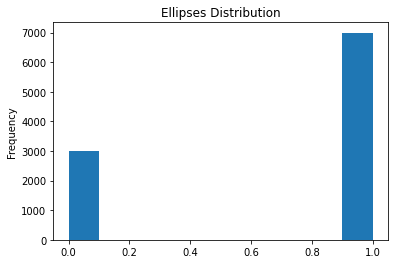

In [80]:
df['is_ellipse'].astype(np.float32).plot.hist(title='Ellipses Distribution');

##### From the histogram above its clear that data has small bias toward ellipses. (30% vs 70%)

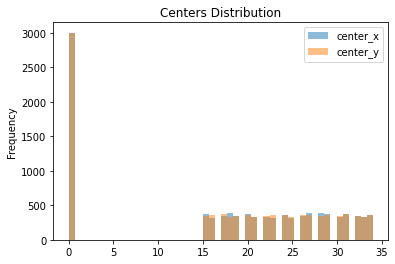

In [81]:
df[['center_x', 'center_y']].plot.hist(bins=50, alpha=0.5, title='Centers Distribution');

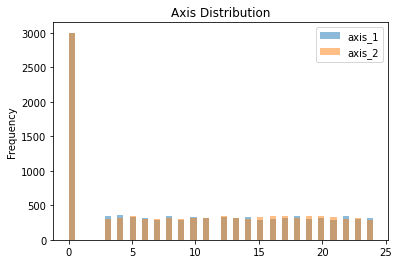

In [82]:
df[['axis_1', 'axis_2']].plot.hist(bins=50, alpha=0.5, title='Axis Distribution');

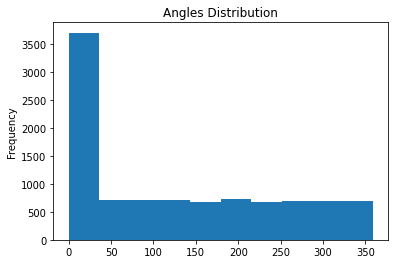

In [83]:
df['angle'].plot.hist(title='Angles Distribution');

#### From the histogram above its clear that ellipses and lines were generated using uniform distribution

https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

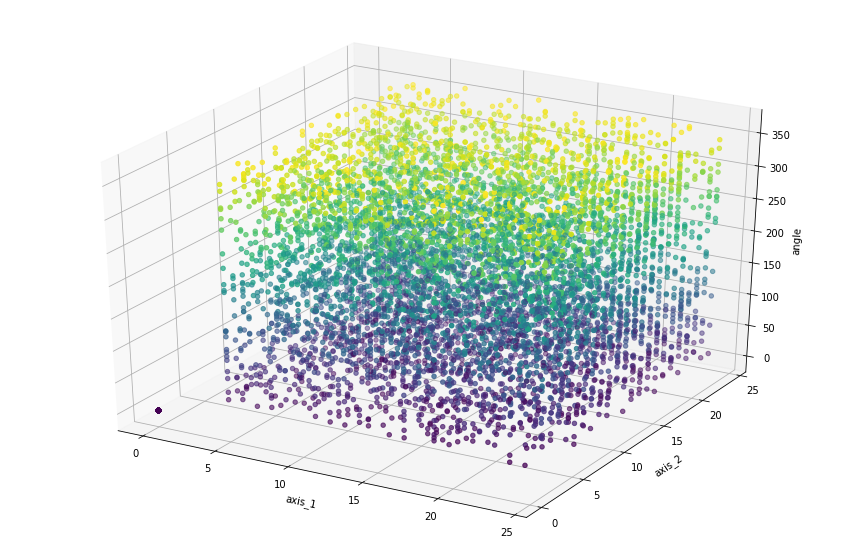

In [84]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')

axis_1 = df['axis_1'].values
axis_2 = df['axis_2'].values
angle  = df['angle'].values

ax.scatter3D(axis_1, axis_2, angle, c=angle);
ax.set_xlabel('axis_1')
ax.set_ylabel('axis_2')
ax.set_zlabel('angle');

#### Auxilary methods

In [86]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def display_dataframe(df, rows=4, cols=4):
    plt.figure(figsize=(10,10))
    for i in range(rows*cols):
        plt.subplot(rows,cols,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        vals = df.values
        plt.imshow(load_img(vals[i][0]), cmap=plt.cm.binary)
        plt.xlabel(f'{vals[i][1:]}')
    plt.show() 
    
# Ellipse are symetrical objects thus:<br> 
#   a. ellipses rotated by angles such as 10 and 190 look the same. Fixed it by removing 180 degrees from angles greater than 180.<br>
#   b. ellipses roatated by 90 degrees or with swapped axis looks same. Fixed it by removing 90 degrees and swapping axis on angles greater than 90    
def align_dataframe(df):
    df = df.copy()
    df.loc[df.angle >= 180, "angle"] = df.angle - 180
    df["angle"], df["axis_1"], df["axis_2"] = np.where(df.angle >= 90, [df["angle"]-90, df["axis_2"], df["axis_1"]], [df["angle"], df["axis_1"], df["axis_2"]])
    return df    

#### Show and Compare visually aligned dataframe

['is_ellipse' 'center_x' 'center_y' 'angle' 'axis_1' 'axis_2']


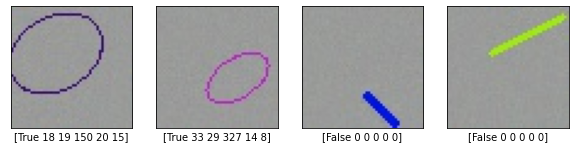

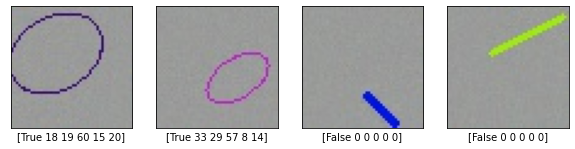

In [87]:
df1 = align_dataframe(df)

print(df.columns.values[1:])

display_dataframe(df.loc[4:8], 1, 4)
display_dataframe(df1.loc[4:8], 1, 4)

## Plain Ellipse Classification

### Build Datasets

In [89]:
def make_dataset(path):
    df = pd.read_csv(path, skipinitialspace=True)
    df = align_dataframe(df)
    images = df.pop('images')
    df = df.astype(np.float32)
    ds = tf.data.Dataset.from_tensor_slices((images.values, df.to_dict('list')))
    return ds

In [90]:
train_dataset = make_dataset('images/train_data.txt')
test_dataset = make_dataset('images/test_data.txt')

#### Show and Verify Inputs

In [92]:
for path, d in train_dataset.take(5):
    print(f'path={path}: is_ellipse={d["is_ellipse"]}, center_x={d["center_x"]}, center_y={d["center_y"]}, angle={d["angle"]}, axis_1={d["axis_1"]}, axis_2={d["axis_2"]}')

path=b'images/train/0000.jpg': is_ellipse=0.0, center_x=0.0, center_y=0.0, angle=0.0, axis_1=0.0, axis_2=0.0
path=b'images/train/0001.jpg': is_ellipse=1.0, center_x=34.0, center_y=32.0, angle=25.0, axis_1=16.0, axis_2=17.0
path=b'images/train/0002.jpg': is_ellipse=0.0, center_x=0.0, center_y=0.0, angle=0.0, axis_1=0.0, axis_2=0.0
path=b'images/train/0003.jpg': is_ellipse=0.0, center_x=0.0, center_y=0.0, angle=0.0, axis_1=0.0, axis_2=0.0
path=b'images/train/0004.jpg': is_ellipse=1.0, center_x=18.0, center_y=19.0, angle=60.0, axis_1=15.0, axis_2=20.0


In [93]:
for path, d in test_dataset.take(5):
    print(f'path={path}: is_ellipse={d["is_ellipse"]}, center_x={d["center_x"]}, center_y={d["center_y"]}, angle={d["angle"]}, axis_1={d["axis_1"]}, axis_2={d["axis_2"]}')

path=b'images/test/0000.jpg': is_ellipse=1.0, center_x=33.0, center_y=30.0, angle=71.0, axis_1=24.0, axis_2=13.0
path=b'images/test/0001.jpg': is_ellipse=1.0, center_x=25.0, center_y=31.0, angle=84.0, axis_1=20.0, axis_2=20.0
path=b'images/test/0002.jpg': is_ellipse=0.0, center_x=0.0, center_y=0.0, angle=0.0, axis_1=0.0, axis_2=0.0
path=b'images/test/0003.jpg': is_ellipse=1.0, center_x=28.0, center_y=29.0, angle=54.0, axis_1=6.0, axis_2=10.0
path=b'images/test/0004.jpg': is_ellipse=0.0, center_x=0.0, center_y=0.0, angle=0.0, axis_1=0.0, axis_2=0.0


#### Auxilary Methods

In [97]:
def preprocess(path, d):
    X = load_img(path)
    y = d['is_ellipse']
    return X, y

def display_ellipse(X, y):
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i], cmap=plt.cm.binary)
        plt.xlabel(f'{y[i]:.3f}')
    plt.show()    

#### Build train and test datasets

In [98]:
train_ds = train_dataset.shuffle(10000).map(preprocess, num_parallel_calls=AUTOTUNE, deterministic=False).batch(16).prefetch(AUTOTUNE)
test_ds = test_dataset.map(preprocess, num_parallel_calls=AUTOTUNE, deterministic=False).batch(16).prefetch(AUTOTUNE)

#### Verify Train Data

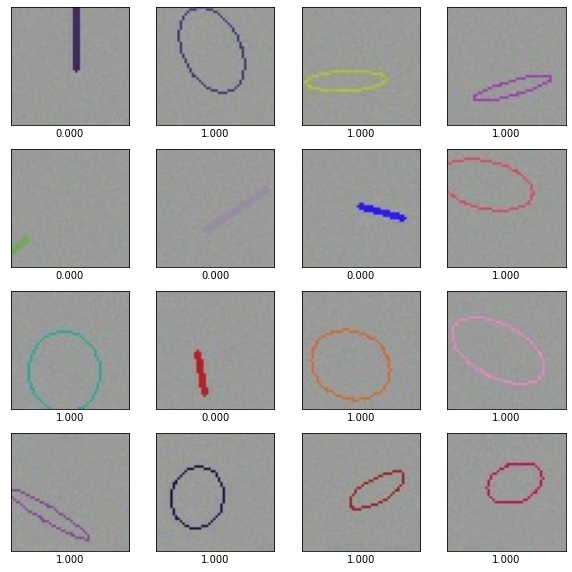

In [99]:
for X, y in train_ds.take(1):
    display_ellipse(X, y)

#### Verify Test Data

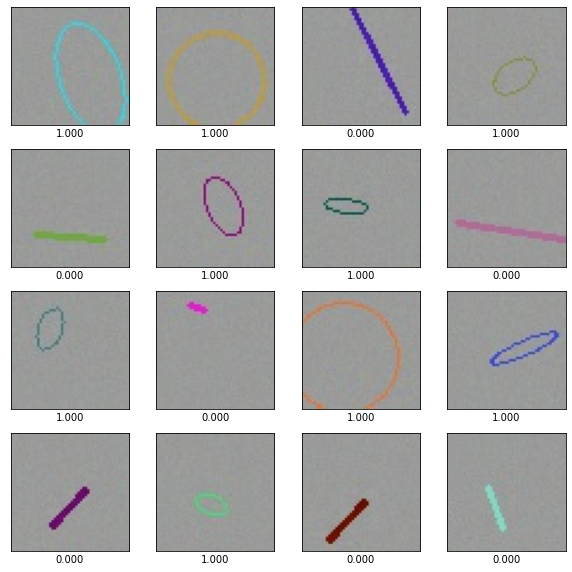

In [100]:
for X, y in test_ds.take(1):
    display_ellipse(X, y)

#### Simple Model

In [101]:
model = models.Sequential()
model.add(layers.Input(shape=(50, 50, 3)))
model.add(layers.Lambda(lambda x: x/255))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])

#### Train

In [102]:
model.fit(train_ds, validation_data=test_ds, epochs=15)

Epoch 1/15
625/625 [==============================] - 3s 5ms/step - loss: 0.4545 - accuracy: 0.8127 - val_loss: 0.3864 - val_accuracy: 0.8570
Epoch 2/15
625/625 [==============================] - 3s 5ms/step - loss: 0.2943 - accuracy: 0.8898 - val_loss: 0.3457 - val_accuracy: 0.9010
Epoch 3/15
625/625 [==============================] - 3s 5ms/step - loss: 0.1937 - accuracy: 0.9265 - val_loss: 0.1773 - val_accuracy: 0.9250
Epoch 4/15
625/625 [==============================] - 3s 5ms/step - loss: 0.0985 - accuracy: 0.9623 - val_loss: 0.0783 - val_accuracy: 0.9740
Epoch 5/15
625/625 [==============================] - 3s 5ms/step - loss: 0.0430 - accuracy: 0.9830 - val_loss: 0.0435 - val_accuracy: 0.9860
Epoch 6/15
625/625 [==============================] - 3s 5ms/step - loss: 0.0356 - accuracy: 0.9863 - val_loss: 0.0281 - val_accuracy: 0.9930
Epoch 7/15
625/625 [==============================] - 3s 5ms/step - loss: 0.0326 - accuracy: 0.9883 - val_loss: 0.0243 - val_accuracy: 0.9880
Epoch 

#### From the simple model results its clear that the ellipses datastes can be classified almost perfectly.

## Ellipse Parametrs Classification

#### Auxilary Methods

In [ ]:
def preprocess(path, d):
    X = load_img(path)
    X = tf.cast(X, tf.float32)
    X = tf.keras.applications.mobilenet.preprocess_input(X)   
    is_ellipse = d['is_ellipse']
    center_x = d["center_x"]
    center_y = d["center_y"]
    angle = d["angle"]
    axis_1 = d["axis_1"]
    axis_2 = d["axis_2"]
    y = tf.stack([is_ellipse, center_x, center_y, axis_1, axis_2, angle], axis=-1)
    return X, y

#### Build train and test datasets

In [104]:
train_ds = train_dataset.shuffle(10000).map(preprocess, num_parallel_calls=AUTOTUNE, deterministic=False).batch(128).prefetch(AUTOTUNE)
test_ds = test_dataset.map(preprocess, num_parallel_calls=AUTOTUNE, deterministic=False).batch(16).prefetch(AUTOTUNE)

#### Verify Train Inputs

In [106]:
for X, y in train_ds.take(1):
    print(X.shape, y.shape)
    print(y[:10])

(128, 50, 50, 3) (128,)
tf.Tensor([1. 1. 1. 1. 0. 1. 0. 1. 1. 1.], shape=(10,), dtype=float32)


#### Verify Test Inputs

In [107]:
for X, y in test_ds.take(1):
    print(X.shape, y.shape)
    print(y[:10])

(16, 50, 50, 3) (16,)
tf.Tensor([1. 1. 0. 1. 0. 1. 1. 0. 1. 0.], shape=(10,), dtype=float32)


### Custom Loss Function

logcosh vs huber vs L2<br>
https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0

In [109]:
def custom_loss(y_true, y_pred):
    is_ellipse_loss = losses.binary_crossentropy(y_true[...,0:1], y_pred[...,0:1])
    is_ellipse_loss = tf.reduce_mean(is_ellipse_loss)
    
    is_ellipse = y_true[...,0]
    
    extra_loss = losses.logcosh(y_true[...,1:], y_pred[...,1:])*is_ellipse
    extra_loss = tf.reduce_mean(extra_loss)

    return is_ellipse_loss + extra_loss

#### Model

In [112]:
backbone = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

x = backbone.output
x = layers.Flatten()(x)

is_ellipse = layers.Dense(1, activation='sigmoid')(x)
last = layers.Dense(5, activation=None)(x)

x = tf.concat([is_ellipse, last], axis=-1)

model = tf.keras.Model(inputs=backbone.input, outputs=x)

#model.summary()

In [113]:
model.compile(loss=custom_loss, optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9))

#### Train

In [67]:
model_cp = tf.keras.callbacks.ModelCheckpoint('checkpoints/cp.ckpt', save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(min_lr=0.0001, factor=0.5)

history = model.fit(train_ds, validation_data=test_ds, epochs=100, callbacks=[model_cp, reduce_lr])

Epoch 1/100
78/79 [============================>.] - ETA: 0s - loss: 2.3047
Epoch 00001: val_loss improved from inf to 7.49886, saving model to checkpoints/cp.ckpt
79/79 [==============================] - 6s 76ms/step - loss: 2.3133 - val_loss: 7.4989 - lr: 0.0100
Epoch 2/100
78/79 [============================>.] - ETA: 0s - loss: 2.2875
Epoch 00002: val_loss improved from 7.49886 to 5.92971, saving model to checkpoints/cp.ckpt
79/79 [==============================] - 5s 68ms/step - loss: 2.3004 - val_loss: 5.9297 - lr: 0.0100
Epoch 3/100
78/79 [============================>.] - ETA: 0s - loss: 2.2633
Epoch 00003: val_loss improved from 5.92971 to 5.46764, saving model to checkpoints/cp.ckpt
79/79 [==============================] - 5s 68ms/step - loss: 2.2746 - val_loss: 5.4676 - lr: 0.0100
Epoch 4/100
78/79 [============================>.] - ETA: 0s - loss: 1.9597
Epoch 00004: val_loss did not improve from 5.46764
79/79 [==============================] - 5s 63ms/step - loss: 1.9634 -

#### Load Best Model

In [68]:
model.load_weights('checkpoints/cp.ckpt')
model.evaluate(test_ds)

63/63 [==============================] - 1s 10ms/step - loss: 4.0338


4.033756256103516

### Test results

In [69]:
val_ds = test_dataset.map(preprocess).batch(1)

results = [(y[0].numpy(),model(X)[0].numpy()) for X, y in val_ds]

### Ellipse Classification Accuracy

In [70]:
y_true = [y[0] for y,p in results]
y_pred = [p[0] > 0.5 for y,p in results]
    
score = accuracy_score(y_true, y_pred)

print(f'Accuracy: {score}')

Accuracy: 1.0


The result 100% is ok since this is generated data without noise and misclassification

### Angle Error

In [71]:
y_true = [y[5] for y,p in results if y[0] == 1]
y_pred = [p[5] for y,p in results if y[0] == 1]

error = mean_absolute_error(y_true, y_pred)

print(f'Error: {error}\n')

for y,p in list(zip(y_true, y_pred))[:10]:
    print(f'y={y}, p={p}')

Error: 5.872804164886475

y=71.0, p=71.20735168457031
y=84.0, p=31.610759735107422
y=54.0, p=58.19108581542969
y=68.0, p=65.5582504272461
y=7.0, p=6.506479263305664
y=19.0, p=18.78134536743164
y=30.0, p=52.935882568359375
y=66.0, p=66.67720794677734
y=20.0, p=25.08112335205078
y=12.0, p=8.704069137573242


This is slightly above 5%, in order to improve I would use classification approach instead of regression. 
Basically divide angle into 90 bins and update model with softmax head

### Centers Error

In [116]:
y_true = [y[1:3] for y,p in results if y[0] == 1]
y_pred = [np.round(p[1:3]) for y,p in results if y[0] == 1]

error = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'Error: {error}\n')

for y,p in list(zip(y_true, y_pred))[:10]:
    print(f'y={y}, p={p}')

Error: 0.6009923815727234

y=[33. 30.], p=[33. 30.]
y=[25. 31.], p=[25. 31.]
y=[28. 29.], p=[28. 29.]
y=[28. 24.], p=[28. 24.]
y=[18. 24.], p=[19. 24.]
y=[16. 16.], p=[16. 16.]
y=[17. 28.], p=[18. 29.]
y=[32. 24.], p=[32. 24.]
y=[23. 30.], p=[24. 31.]
y=[26. 31.], p=[26. 31.]


### Axis Error

In [117]:
y_true = [y[3:5] for y,p in results if y[0] == 1]
y_pred = [np.round(p[3:5]) for y,p in results if y[0] == 1]

error = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'Error: {error}\n')

for y,p in list(zip(y_true, y_pred))[:10]:
    print(f'{y}, {p}')

Error: 1.2143162488937378

[24. 13.], [24. 13.]
[20. 20.], [20. 20.]
[ 6. 10.], [ 6. 10.]
[13.  7.], [13.  7.]
[9. 3.], [10.  3.]
[5. 9.], [5. 9.]
[23. 23.], [23. 23.]
[ 3. 15.], [ 3. 16.]
[7. 4.], [7. 4.]
[22. 15.], [22. 15.]
